# Driver of Heterophily: Toxicity Analysis `/r/PC` and `/r/PCM`
- To replicate: **Figure 7**, **Figure B.8**

In [1]:
# Packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind
import seaborn as sns
from pathlib import Path
import sys

sys.path += ['../']

from config import processed_data_path, raw_data_path, figure_path

# Parameters
DATA_PATH = raw_data_path
OUTPUT_PATH = processed_data_path
FIGURES_PATH = figure_path

SUBREDDITS = {
    'PoliticalCompass': 'PC',
    'PoliticalCompassMemes': 'PCM'}

# Flairs order for plots
SOCIAL_ORDER = ['Lib', 'Centrist', 'Auth']
ECONOMIC_ORDER = ['Left', 'Centrist', 'Right']

# Plot style
sns.set_context('talk', rc={'font.size': 14.0,
                            'axes.labelsize': 14.0,
                            'axes.titlesize': 14.0,
                            'xtick.labelsize': 12.0,
                            'ytick.labelsize': 12.0,
                            'legend.fontsize': 12.0,
                            'legend.title_fontsize': 16.0,
                            'patch.linewidth': 1.5,
                            'font.family': 'serif',
                            'font.serif': 'Linux Libertine O',
                           }
               )
# Functions

def generate_sample(parent_indices: np.array, child_indices: np.array, switch_threshold: int, 
                    verbose: bool=False) -> np.array:
    '''Returns shuffled_parents array.
        Features:
        -  No selfloops (checked with child_indices)
        -  switch_threshold changes
    '''
    shuffled_parents = parent_indices.copy()
    switch_count = 0
    
    while switch_count < switch_threshold:
        if verbose:
            print(f"Numb swaps {switch_count:_}/{switch_threshold:_}", end="\r")
        # Select a random index to switch
        idx = np.random.choice(len(shuffled_parents))
        
        # Select another random index to switch with, avoiding self-loops
        swap_with = np.random.choice(len(shuffled_parents))
        while swap_with == idx or \
              shuffled_parents[swap_with] == child_indices[idx] or \
              shuffled_parents[idx] == child_indices[swap_with]:
            swap_with = np.random.choice(len(shuffled_parents))

        shuffled_parents[idx], shuffled_parents[swap_with] = shuffled_parents[swap_with], shuffled_parents[idx]
        switch_count += 1
        
    return shuffled_parents


def generate_n_samples(parent_indices, child_indices, switch_threshold, n_samples, verbose=False):
    '''Returns list of n_samples different samples of parent_indices calling generate_sample
    '''
    samples = []
    while len(samples) < n_samples:
        print(f"sample {len(samples)+1:_}/{n_samples:_}")
        new_sample = generate_sample(parent_indices, child_indices, switch_threshold, verbose)
        
        # Check if the new sample is different from the already generated samples
        is_in = np.any([np.array_equal(new_sample, sample) for sample in samples])
        if not is_in:
            samples.append(new_sample)
        
    return samples


def get_toxicity_ratio(toxicity: pd.DataFrame, null_model: pd.DataFrame, 
                       axes: str, index_order: list) -> pd.DataFrame:

    # Use pivot_table to calculate the mean for each combination of c_economic and p_economic
    num = toxicity.groupby([f'c_{axes}', f'p_{axes}'])['toxicity'].mean().unstack().reindex(
                                index=index_order,
                                columns=index_order)
    den = null_model.groupby([f'c_{axes}', f'p_{axes}'])['toxicity'].mean().unstack().reindex(
                                index=index_order,
                                columns=index_order)
    ratio = num / den

    # Remove the row index name and column index name
    ratio.index.name = None
    ratio.columns.name = None
    
    return ratio

def get_toxicity_stat_significance(toxicity: pd.DataFrame, null_model: pd.DataFrame, 
                                   axes: str, index_order: list, alpha: float =0.05) -> pd.DataFrame:
    """Returns df with index_order x index_order with p-values
    """
    test_results = pd.DataFrame(index=index_order, columns=index_order)

    grouped_toxicity = toxicity.groupby([f'c_{axes}', f'p_{axes}'])['toxicity']
    grouped_null_model = null_model.groupby([f'c_{axes}', f'p_{axes}'])['toxicity']

    for (c_econ, p_econ), toxicity_group in grouped_toxicity:
        null_model_group = grouped_null_model.get_group((c_econ, p_econ))
        
        __ttest_statistic, p_value = ttest_ind(toxicity_group, null_model_group)
        
        test_results.at[c_econ, p_econ] = p_value <= alpha
    return test_results

np.random.seed(42)

### 0. Load data

In [2]:
toxicity = {}
for S in SUBREDDITS:
    filename = Path(f"{OUTPUT_PATH}sampled_edges_anonymized_with_toxicity_{SUBREDDITS[S]}.parquet")

    if not filename.exists():
        print(f"File {filename} does not exist --> Sampling")
        toxicity[S] = pd.read_csv(DATA_PATH + f"edges_anonymized_with_toxicity_{SUBREDDITS[S]}.csv")
        
        toxicity[S] = toxicity[S][~toxicity[S].toxicity.isnull()].sample(100_000)

        # indexing names
        name2index = {name : i for i, name in enumerate(set(toxicity[S].child).union(set(toxicity[S].parent)))}

        toxicity[S]['child_index'] = toxicity[S].child.apply(lambda x: name2index[x])
        toxicity[S]['parent_index'] = toxicity[S].parent.apply(lambda x: name2index[x])

        toxicity[S].to_parquet(filename)
    else:
        print(f"File {filename} does exist --> Loading")
        toxicity[S] = pd.read_parquet(filename)

File ../../data/processed/sampled_edges_anonymized_with_toxicity_PC.parquet does not exist --> Sampling
File ../../data/processed/sampled_edges_anonymized_with_toxicity_PCM.parquet does not exist --> Sampling


In [3]:
n_samples = 100

null_models = {}

for S in SUBREDDITS:
    filename = Path(f"{OUTPUT_PATH}null_models_toxicity_{SUBREDDITS[S]}.parquet")
    if not filename.exists():
        print(f"File {filename} does not exist --> Sampling Null model")

        # Sampling null models samples --> shuffled parent ids
        parent_indices = toxicity[S]['parent_index'].to_numpy()
        child_indices = toxicity[S]['child_index'].to_numpy()
        switch_threshold = np.log10(len(parent_indices)) * len(parent_indices)
        parent_samples = generate_n_samples(parent_indices, child_indices, switch_threshold, n_samples, False)
        
        # build unique null model as concatenation of samples
        dfs = []
        for sample in parent_samples:
            c_columns = toxicity[S].iloc[sample][['c_social', 'c_economic']].reset_index(drop=True)
            p_columns = toxicity[S][['p_social', 'p_economic', 'toxicity']].reset_index(drop=True)
            concatenated_df = pd.concat([c_columns, p_columns], axis=1)
            dfs.append(concatenated_df)

        null_models[S] = pd.concat(dfs)
        null_models[S].to_parquet(filename)

    else:
        print(f"File {filename} does exist --> Loading Null model samples")

        null_models[S] = pd.read_parquet(filename)

File ../../data/processed/null_models_toxicity_PC.parquet does not exist --> Sampling Null model
sample 1/100
sample 2/100
sample 3/100
sample 4/100
sample 5/100
sample 6/100
sample 7/100
sample 8/100
sample 9/100
sample 10/100
sample 11/100
sample 12/100
sample 13/100
sample 14/100
sample 15/100
sample 16/100
sample 17/100
sample 18/100
sample 19/100
sample 20/100
sample 21/100
sample 22/100
sample 23/100
sample 24/100
sample 25/100
sample 26/100
sample 27/100
sample 28/100
sample 29/100
sample 30/100
sample 31/100
sample 32/100
sample 33/100
sample 34/100
sample 35/100
sample 36/100
sample 37/100
sample 38/100
sample 39/100
sample 40/100
sample 41/100
sample 42/100
sample 43/100
sample 44/100
sample 45/100
sample 46/100
sample 47/100
sample 48/100
sample 49/100
sample 50/100
sample 51/100
sample 52/100
sample 53/100
sample 54/100
sample 55/100
sample 56/100
sample 57/100
sample 58/100
sample 59/100
sample 60/100
sample 61/100
sample 62/100
sample 63/100
sample 64/100
sample 65/100
sa

### 1. Toxicity analysis

In [4]:
alpha = .05

toxicity_by_social = {}
toxicity_by_economic = {}

toxicity_by_social_significant = {}
toxicity_by_economic_significant = {}

for S in SUBREDDITS:

    toxicity_by_social[S] = (get_toxicity_ratio(toxicity[S], null_models[S], 'social', SOCIAL_ORDER)
                             .rename(index={'Centrist': 'Center'}, columns={'Centrist': 'Center'})
                            )
    toxicity_by_social_significant[S] = (get_toxicity_stat_significance(toxicity[S], null_models[S],
                                                                       'social', SOCIAL_ORDER, 
                                                                       alpha=alpha)
                                         .rename(index={'Centrist': 'Center'}, columns={'Centrist': 'Center'})
                                        )

    toxicity_by_economic[S] = (get_toxicity_ratio(toxicity[S], null_models[S], 'economic', ECONOMIC_ORDER)
                               .rename(index={'Centrist': 'Center'}, columns={'Centrist': 'Center'})
                              )
    toxicity_by_economic_significant[S] = (get_toxicity_stat_significance(toxicity[S], null_models[S],
                                                                         'economic', ECONOMIC_ORDER,
                                                                         alpha=alpha)
                                           .rename(index={'Centrist': 'Center'}, columns={'Centrist': 'Center'})
                                          )

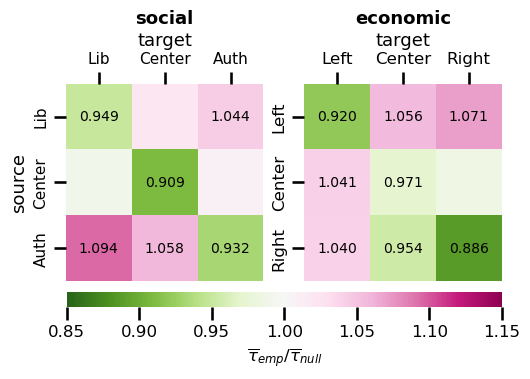

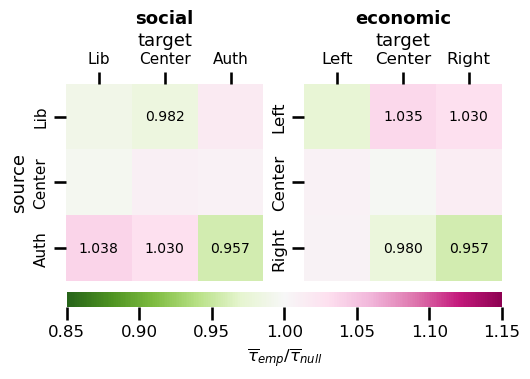

In [5]:
# Separated plots toxicity ratios
for S in SUBREDDITS:
    fig = plt.figure(layout='constrained', figsize=(5,5))
    ax = fig.subplot_mosaic('''
    AB
    ''')

    vmin, vmax = (0.85, 1.15)
    annot = False
    cmap = 'PiYG_r'

    sns.heatmap(toxicity_by_social[S],
                cmap=cmap,
                annot=annot, fmt='.3f', annot_kws={'fontsize': 10},
                vmin=vmin, vmax=vmax,
                cbar=False,
                square=True,
                ax=ax['A']
               )
    sns.heatmap(toxicity_by_economic[S],
                cmap=cmap,
                annot=annot, fmt='.3f', annot_kws={'fontsize': 10},
                vmin=vmin, vmax=vmax,
                cbar=False,
                square=True,
                ax=ax['B']
               )

    def annotate_heatmap(ax, significance_df, values_df):
        for i, row in enumerate(significance_df.index):
            for j, col in enumerate(significance_df.columns):
                if significance_df.loc[row, col]: # Check for True value in the corresponding cell
                    value = values_df.loc[row, col]
                    ax.text(j + 0.5, i + 0.5, f"{value:.3f}", ha='center', va='center', fontsize=10, color='black')

    # Annotating each subplot
    annotate_heatmap(ax['A'], toxicity_by_social_significant[S], toxicity_by_social[S])
    annotate_heatmap(ax['B'], toxicity_by_economic_significant[S], toxicity_by_economic[S])

    ax['A'].set_title('social', weight='bold', fontsize=13)
    ax['B'].set_title('economic', weight='bold', fontsize=13)
    ax['A'].set_ylabel('source', fontsize=13)
    ax['B'].set_ylabel('')
    ax['A'].xaxis.set_ticks_position('top')
    ax['A'].xaxis.set_label_position('top')
    ax['A'].set_xlabel('target', fontsize=13)
    ax['B'].xaxis.set_ticks_position('top')
    ax['B'].xaxis.set_label_position('top')
    ax['B'].set_xlabel('target', fontsize=13)
    
    ax['A'].tick_params(which='both', labelsize=11)

    im = plt.gca().get_children()[0]
    cax = fig.add_axes([0.122,0.25,0.870,0.03])
    c = fig.colorbar(im, cax=cax,
                     orientation = 'horizontal')
    c.outline.set_linewidth(0)
    c.set_label(label=r'$\overline{\tau}_{emp} / \overline{\tau}_{null}$', size=12)

    plt.savefig(FIGURES_PATH + f'4_driving_heterophily_{SUBREDDITS[S]}.pdf', bbox_inches='tight')
    plt.show()